Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function

This is done with SC.

In [1]:
# Run an EasyVVUQ campaign to analyze the sensitivity for the Ishigami function
# This is done with SC.
import os
import easyvvuq as uq
import chaospy as cp
import pickle
import numpy as np
import matplotlib.pylab as plt
import time
import pandas as pd

In [2]:
np.__version__

'1.19.4'

In [3]:
# Define the Ishigami function
def ishigamiSA(a,b):
    '''Exact sensitivity indices of the Ishigami function for given a and b.
    From https://openturns.github.io/openturns/master/examples/meta_modeling/chaos_ishigami.html
    '''
    var = 1.0/2 + a**2/8 + b*np.pi**4/5 + b**2*np.pi**8/18
    S1 = (1.0/2 + b*np.pi**4/5+b**2*np.pi**8/50)/var
    S2 = (a**2/8)/var
    S3 = 0
    S13 = b**2*np.pi**8/2*(1.0/9-1.0/25)/var
    exact = {
            'expectation' : a/2,
            'variance' : var,
            'S1' : (1.0/2 + b*np.pi**4/5+b**2*np.pi**8.0/50)/var,
            'S2' : (a**2/8)/var,
            'S3' : 0,
            'S12' : 0,
            'S23' : 0,
            'S13' : S13,
            'S123' : 0,
            'ST1' : S1 + S13,
            'ST2' : S2,
            'ST3' : S3 + S13
            }
    return exact

Ishigami_a = 7.0
Ishigami_b = 0.1
exact = ishigamiSA(Ishigami_a, Ishigami_b)

In [4]:
# define a model to run the Ishigami code directly from python, expecting a dictionary and returning a dictionary
def run_ishigami_model(input):
    import Ishigami
    qois = ["Ishigami"]
    del input['out_file']
    return {qois[0]: Ishigami.evaluate(**input)}

In [5]:
# Define parameter space
def define_params():
    return {
        "x1":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x2":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "x3":       {"type": "float",   "min": -np.pi,     "max": np.pi,      "default": 0.0},
        "a":        {"type": "float",   "min": Ishigami_a, "max": Ishigami_a, "default": Ishigami_a},
        "b":        {"type": "float",   "min": Ishigami_b, "max": Ishigami_b, "default": Ishigami_b},
        "out_file": {"type": "string",  "default": "output.csv"}
    }

In [6]:
# Define parameter space
def define_vary():
    return {
        "x1":   cp.Uniform(-np.pi, np.pi),
        "x2":   cp.Uniform(-np.pi, np.pi),
        "x3":   cp.Uniform(-np.pi, np.pi)
    }

In [7]:
# Set up and run a campaign
def run_campaign(sc_order=2, use_files=False):

    times = np.zeros(7)

    time_start = time.time()
    time_start_whole = time_start

    # Set up a fresh campaign called "Ishigami_sc."
    my_campaign = uq.Campaign(name='Ishigami_sc.')


    # Create an encoder and decoder for SC test app
    if use_files:
        encoder = uq.encoders.GenericEncoder(template_fname='Ishigami.template',
                                             delimiter='$',
                                             target_filename='Ishigami_in.json')

        decoder = uq.decoders.SimpleCSV(target_filename="output.csv",
                                        output_columns=["Ishigami"])

        execute = uq.actions.ExecuteLocal('python3 %s/Ishigami.py Ishigami_in.json' % (os.getcwd()))

        actions = uq.actions.Actions(uq.actions.CreateRunDirectory('/tmp'), 
                          uq.actions.Encode(encoder), execute, uq.actions.Decode(decoder))
    else:
        actions = uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model))

    # Add the app (automatically set as current app)
    my_campaign.add_app(name="Ishigami", params=define_params(), actions=actions)

    # Create the sampler
    time_end = time.time()
    times[1] = time_end-time_start
    print('Time for phase 1 = %.3f' % (times[1]))

    time_start = time.time()
    # Associate a sampler with the campaign
    my_campaign.set_sampler(uq.sampling.SCSampler(vary=define_vary(), polynomial_order=sc_order))

    # Will draw all (of the finite set of samples)
    my_campaign.draw_samples()
    print('Number of samples = %s' % my_campaign.get_active_sampler().count)

    time_end = time.time()
    times[2] = time_end-time_start
    print('Time for phase 2 = %.3f' % (times[2]))

    time_start = time.time()
    # Run the cases
    my_campaign.execute(sequential=True).collate()

    time_end = time.time()
    times[3] = time_end-time_start
    print('Time for phase 3 = %.3f' % (times[3]))

    time_start = time.time()
    # Get the results
    results_df = my_campaign.get_collation_result()

    time_end = time.time()
    times[4] = time_end-time_start
    print('Time for phase 4 = %.3f' % (times[4]))

    time_start = time.time()
    # Post-processing analysis
    results = my_campaign.analyse(qoi_cols=["Ishigami"])
    
    time_end = time.time()
    times[5] = time_end-time_start
    print('Time for phase 5 = %.3f' % (times[5]))

    time_start = time.time()
    # Save the results
    pickle.dump(results, open('Ishigami_results.pickle','bw'))
    time_end = time.time()
    times[6] = time_end-time_start
    print('Time for phase 6 = %.3f' % (times[6]))

    times[0] = time_end - time_start_whole

    return results_df, results, times, sc_order, my_campaign.get_active_sampler().count

In [8]:
# Calculate the stochastic colocation expansion for a range of orders

R = {}
for sc_order in range(1, 21):
    R[sc_order] = {}
    (R[sc_order]['results_df'], 
     R[sc_order]['results'], 
     R[sc_order]['times'], 
     R[sc_order]['order'], 
     R[sc_order]['number_of_samples']) = run_campaign(sc_order=sc_order, use_files=False)

Time for phase 1 = 0.023
Number of samples = 8
Time for phase 2 = 0.028
Time for phase 3 = 0.009
Time for phase 4 = 0.002
Time for phase 5 = 0.010
Time for phase 6 = 0.001
Time for phase 1 = 0.009
Number of samples = 27
Time for phase 2 = 0.045
Time for phase 3 = 0.013
Time for phase 4 = 0.002
Time for phase 5 = 0.022
Time for phase 6 = 0.001
Time for phase 1 = 0.008
Number of samples = 64
Time for phase 2 = 0.068
Time for phase 3 = 0.019
Time for phase 4 = 0.003
Time for phase 5 = 0.046
Time for phase 6 = 0.001
Time for phase 1 = 0.009
Number of samples = 125
Time for phase 2 = 0.100
Time for phase 3 = 0.033
Time for phase 4 = 0.004
Time for phase 5 = 0.093
Time for phase 6 = 0.001
Time for phase 1 = 0.010
Number of samples = 216
Time for phase 2 = 0.146
Time for phase 3 = 0.056
Time for phase 4 = 0.005
Time for phase 5 = 0.151
Time for phase 6 = 0.001
Time for phase 1 = 0.010
Number of samples = 343
Time for phase 2 = 0.195
Time for phase 3 = 0.127
Time for phase 4 = 0.010
Time for p

In [9]:
# save the results

pickle.dump(R, open('collected_results.pickle','bw'))

In [10]:
# produce a table of the time taken for various phases
# the phases are:
#   1: creation of campaign
#   2: creation of samples
#   3: running the cases
#   4: calculation of statistics including Sobols
#   5: returning of analysed results
#   6: saving campaign and pickled results

Timings = pd.DataFrame(np.array([R[r]['times'] for r in list(R.keys())]), 
             columns=['Total', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 5', 'Phase 6'], 
             index=[R[r]['order'] for r in list(R.keys())])
Timings.to_csv(open('Timings.csv', 'w'))
display(Timings)

,Total,Phase 1,Phase 2,Phase 3,Phase 4,Phase 5,Phase 6
1,0.072860,0.022665,0.027873,0.009291,0.002310,0.009712,0.000659
2,0.093311,0.008834,0.045388,0.013045,0.002478,0.021778,0.001309
3,0.145176,0.008458,0.067645,0.018558,0.003289,0.046203,0.000723
4,0.240465,0.009327,0.100292,0.032625,0.003958,0.092968,0.000936
5,0.369132,0.009985,0.146285,0.055577,0.004787,0.151238,0.000987
6,0.602916,0.010210,0.195435,0.126957,0.010233,0.258520,0.001249
7,0.794899,0.009558,0.266064,0.123398,0.011204,0.382822,0.001537
8,1.094592,0.009978,0.340837,0.166158,0.014418,0.560874,0.001978
9,1.511983,0.010128,0.432782,0.276734,0.017879,0.771604,0.002553
10,1.992577,0.015721,0.546208,0.338360,0.022191,1.066667,0.002986


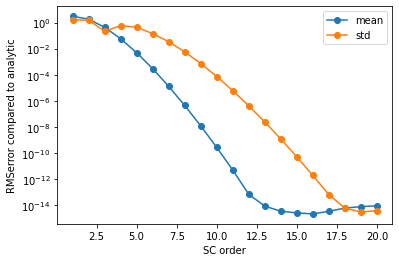

In [11]:
# plot the convergence of the mean and standard deviation to that of the highest order

mean_analytic = exact['expectation']
std_analytic = np.sqrt(exact['variance'])

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'mean') - mean_analytic) for o in O],
             'o-', label='mean')
plt.semilogy([o for o in O], 
             [np.abs(R[o]['results'].describe('Ishigami', 'std') - std_analytic) for o in O],
             'o-', label='std')
plt.xlabel('SC order')
plt.ylabel('RMSerror compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_mean_std.png')
plt.savefig('Convergence_mean_std.pdf')

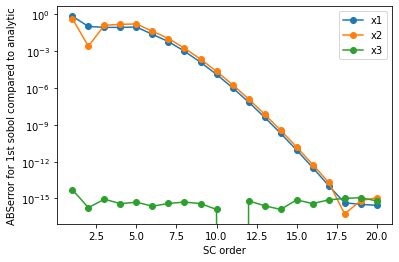

In [12]:
# plot the convergence of the first sobol to that of the highest order

sobol_first_exact = {'x1': exact['S1'], 'x2': exact['S2'], 'x3': exact['S3']}

O = [R[r]['order'] for r in list(R.keys())]
plt.figure()
for v in list(R[O[0]]['results'].sobols_first('Ishigami').keys()):
    plt.semilogy([o for o in O],
                 [np.abs(R[o]['results'].sobols_first('Ishigami')[v] - sobol_first_exact[v]) for o in O],
                 'o-',
                 label=v)
plt.xlabel('SC order')
plt.ylabel('ABSerror for 1st sobol compared to analytic')
plt.legend(loc=0)
plt.savefig('Convergence_sobol_first.png')
plt.savefig('Convergence_sobol_first.pdf')

In [16]:
# prepare the test data
test_campaign = uq.Campaign(name='Ishigami.')        
test_campaign.add_app(name="Ishigami", params=define_params(), 
                      actions=uq.actions.Actions(uq.actions.ExecutePython(run_ishigami_model)))
test_campaign.set_sampler(uq.sampling.quasirandom.LHCSampler(vary=define_vary(), count=100))
test_campaign.execute(nsamples=1000, sequential=True).collate()
test_df = test_campaign.get_collation_result()

In [14]:
# calculate the SC surrogates
if __name__ == '__main__':

    test_points = test_df[test_campaign.get_active_sampler().vary.get_keys()]
    test_results = np.squeeze(test_df['Ishigami'].values)
    test_predictions = {}
    for i in list(R.keys()):
        test_predictions[i] = np.squeeze(np.array(R[i]['results'].surrogate()(test_points)['Ishigami']))

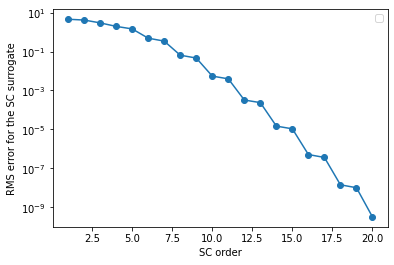

In [15]:
# plot the convergence of the surrogate
if __name__ == '__main__':
    _o = []
    _RMS = []
    for r in R.values():
        _RMS.append((np.sqrt((((test_predictions[r['order']] - test_results))**2).mean())))
        _o.append(r['order'])

    plt.figure()
    plt.semilogy(_o, _RMS, 'o-')
    plt.xlabel('SC order')
    plt.ylabel('RMS error for the SC surrogate')
    plt.legend(loc=0)
    plt.savefig('Convergence_SC_surrogate.png')
    plt.savefig('Convergence_SC_surrogate.pdf')